Дано:
2 датафрейма с постами и соответствующими юзерами, поставивших реакции

Оставляем только релевантных юзеров

In [1]:
import pandas as pd
import numpy as np
import json
from wordcloud import WordCloud

import matplotlib.pyplot as plt

In [2]:
df_1 = pd.read_json('datasets/nastavnichestvo_it_final.json', orient='index')
df_2 = pd.read_json('datasets/prepodavanie_it_final.json', orient='index')
df_3 = pd.read_json('datasets/mentor_it_posts.json', orient='index')

In [3]:
df = pd.concat([df_1,df_2, df_3]).reset_index(drop=True)
df

,0,1
0,Будет ли еще мой менторский курс по IT Рекрутм...,{'https://www.linkedin.com/in/ACoAABdk1nkBsBNQ...
1,Всем привет - Нахожусь в поиске работы по спец...,{'https://www.linkedin.com/in/ACoAAAHO6ccBTyhb...
2,Ищем к себе в команду Системного аналитика.Как...,{'https://www.linkedin.com/in/ACoAADIb9yEBkqOP...
3,08.08.22 - 1й день с командой IT_One.Долгождан...,{'https://www.linkedin.com/in/ACoAADlYxTkBWDm_...
4,Как менторам развивать Data Science сообщество...,{'https://www.linkedin.com/in/ACoAADe6becBwuAU...
...,...,...
491,Ние от Фондация Предай Нататък сме безкрайно б...,{'https://www.linkedin.com/in/ACoAAAQTf7oBjOcB...
492,През изминалата седмица един от нашите основат...,{'https://www.linkedin.com/in/ACoAAD5pfkUBtWX3...
493,През изминалата седмица един от нашите основат...,{'https://www.linkedin.com/in/ACoAADzyGWUBd59E...
494,През изминалата седмица един от нашите основат...,{'https://www.linkedin.com/in/ACoAADzB48MBmH69...


In [4]:
df[1][0]

{'https://www.linkedin.com/in/ACoAABdk1nkBsBNQnzJyN8ucY8AO8s4Ex33CWuM': ['Leila Rajapova',
  'IT recruiter'],
 'https://www.linkedin.com/in/ACoAADcbdQIBouDEG4rTsxN3e3AWQDGpzt3neL4': ['Анастасия Прохорова',
  'IT recruiter 🔍'],
 'https://www.linkedin.com/in/ACoAADCkYMwB61VZ3NyE77IGOx0XAlJZrM_bN1Y': ['Bekzod Khabibullaev',
  'Business Management'],
 'https://www.linkedin.com/in/ACoAADskSvUBmr0u-Je9eX1CLhHXqtzilIB4j74': ['Dmitry Drobov',
  'QA Engineer with 1+ year experience | Web | Mobile | Blockchain'],
 'https://www.linkedin.com/in/ACoAABSNNvYBouwqj96_Ju9wOZJJIESC2fGNnfs': ['Дмитрий Каулькин',
  '--'],
 'https://www.linkedin.com/in/ACoAAEBECeoBJiCXX92eHtohZaGwUfzrZjuBs4c': ['Ekaterina Milichkina',
  'IT Recruiter'],
 'https://www.linkedin.com/in/ACoAAA69QbcBdsk4vJLyM1Jzjjn_tY3IJROS2PQ': ['Mark Beseliya',
  'Project Manager Product Manager 8+ years | IT international vendors | SMB companies'],
 'https://www.linkedin.com/in/ACoAADyOO1oBOYhzQeCziPm25XNSIOXFOnVdwY0': ['Anastasia Khutornay

В идеале нам нужно сходить на линк каждого юзера, отреагировавшего на пост, но алгоритмы Linkedin'а нас быстро забанят. Поэтому будем работать с тем, что есть

In [5]:
df.columns = ['post_text','reacted_users_info']
df

,post_text,reacted_users_info
0,Будет ли еще мой менторский курс по IT Рекрутм...,{'https://www.linkedin.com/in/ACoAABdk1nkBsBNQ...
1,Всем привет - Нахожусь в поиске работы по спец...,{'https://www.linkedin.com/in/ACoAAAHO6ccBTyhb...
2,Ищем к себе в команду Системного аналитика.Как...,{'https://www.linkedin.com/in/ACoAADIb9yEBkqOP...
3,08.08.22 - 1й день с командой IT_One.Долгождан...,{'https://www.linkedin.com/in/ACoAADlYxTkBWDm_...
4,Как менторам развивать Data Science сообщество...,{'https://www.linkedin.com/in/ACoAADe6becBwuAU...
...,...,...
491,Ние от Фондация Предай Нататък сме безкрайно б...,{'https://www.linkedin.com/in/ACoAAAQTf7oBjOcB...
492,През изминалата седмица един от нашите основат...,{'https://www.linkedin.com/in/ACoAAD5pfkUBtWX3...
493,През изминалата седмица един от нашите основат...,{'https://www.linkedin.com/in/ACoAADzyGWUBd59E...
494,През изминалата седмица един от нашите основат...,{'https://www.linkedin.com/in/ACoAADzB48MBmH69...


У нас нет большого размеченного датасета чтобы сделать ML-модель определяющую насколько тот или иной юзер для нас релевантен. Поэтому будем визуализировать "облако названий профессий" и убирать из них не-it и около-it специальности.

Оставим профессии со словами `middle`, `senior`, `lead` и исключим нерелевантные специальности

In [6]:
def relevant_job_title_extraction(reactions_info):
    '''функция фильтрует профессии и оставляет только те, которые соответствуют релевантному паттерну'''
    relevant_list = ['senior', 'middle','lead']
    not_relevant_list = ['hr','recruiter','manager','looking','consultant','seo','консультант', 'management']
    job_titles = []
    for user_info in reactions_info.values():
        true_pattern = [x in user_info[1].lower() for x in relevant_list]
        wrong_pattern = [x in user_info[1].lower() for x in not_relevant_list]
        pattern = any(true_pattern) and not any(wrong_pattern)
        if pattern:
            job_titles.append(user_info[1])
    job_titles = ' '.join(job_titles)
    return job_titles

In [7]:
df['job_titles'] = df.reacted_users_info.apply(relevant_job_title_extraction)
df

,post_text,reacted_users_info,job_titles
0,Будет ли еще мой менторский курс по IT Рекрутм...,{'https://www.linkedin.com/in/ACoAABdk1nkBsBNQ...,"Senior DevOps, Python, Go, Terraform, AWS Seni..."
1,Всем привет - Нахожусь в поиске работы по спец...,{'https://www.linkedin.com/in/ACoAAAHO6ccBTyhb...,
2,Ищем к себе в команду Системного аналитика.Как...,{'https://www.linkedin.com/in/ACoAADIb9yEBkqOP...,
3,08.08.22 - 1й день с командой IT_One.Долгождан...,{'https://www.linkedin.com/in/ACoAADlYxTkBWDm_...,Employer brand Lead Lead System Administrator ...
4,Как менторам развивать Data Science сообщество...,{'https://www.linkedin.com/in/ACoAADe6becBwuAU...,Machine Learning Researcher | Academic Leader ...
...,...,...,...
491,Ние от Фондация Предай Нататък сме безкрайно б...,{'https://www.linkedin.com/in/ACoAAAQTf7oBjOcB...,Human Resources Director Commercial & Human Re...
492,През изминалата седмица един от нашите основат...,{'https://www.linkedin.com/in/ACoAAD5pfkUBtWX3...,Senior Quality Assurance Engineer Input Valida...
493,През изминалата седмица един от нашите основат...,{'https://www.linkedin.com/in/ACoAADzyGWUBd59E...,Senior Sales and Customer Advisor SMM Team Lea...
494,През изминалата седмица един от нашите основат...,{'https://www.linkedin.com/in/ACoAADzB48MBmH69...,Input Validation Senior Data Processor Senior ...


Остались только релевантные профессии, соответственно можем почистить датасет от постов с 0 реакций от ЦА. Заодно удалим полные дубликаты постов

In [8]:
filtered_df = df[df['job_titles'] != '']
filtered_df.drop_duplicates('post_text', inplace=True)
filtered_df

C:\Users\Felixalex\AppData\Local\Temp\ipykernel_26512\3575916430.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop_duplicates('post_text', inplace=True)


,post_text,reacted_users_info,job_titles
0,Будет ли еще мой менторский курс по IT Рекрутм...,{'https://www.linkedin.com/in/ACoAABdk1nkBsBNQ...,"Senior DevOps, Python, Go, Terraform, AWS Seni..."
3,08.08.22 - 1й день с командой IT_One.Долгождан...,{'https://www.linkedin.com/in/ACoAADlYxTkBWDm_...,Employer brand Lead Lead System Administrator ...
4,Как менторам развивать Data Science сообщество...,{'https://www.linkedin.com/in/ACoAADe6becBwuAU...,Machine Learning Researcher | Academic Leader ...
5,Пора рассекретится! Начался новый период на бл...,{'https://www.linkedin.com/in/ACoAAD7Ow-sBU2ef...,Senior QA Automation Engineer at OZON.ru Lead ...
6,Завершился третий поток менторской программы д...,{'https://www.linkedin.com/in/ACoAAD-ysXcBrnVM...,Founder GradeBuilder | Lead QA – AstralSoft | ...
...,...,...,...
488,🎓Предикција на согорени калории за време на ве...,{'https://www.linkedin.com/in/ACoAABy0ypIB8JXI...,Senior Officer - Unit for restructuring and wo...
491,Ние от Фондация Предай Нататък сме безкрайно б...,{'https://www.linkedin.com/in/ACoAAAQTf7oBjOcB...,Human Resources Director Commercial & Human Re...
492,През изминалата седмица един от нашите основат...,{'https://www.linkedin.com/in/ACoAAD5pfkUBtWX3...,Senior Quality Assurance Engineer Input Valida...
493,През изминалата седмица един от нашите основат...,{'https://www.linkedin.com/in/ACoAADzyGWUBd59E...,Senior Sales and Customer Advisor SMM Team Lea...


In [9]:
wc = WordCloud(background_color="white", font_path="./arial.ttf", width=1600, height=800, max_words=1000)
wc.generate(' '.join(filtered_df.job_titles))

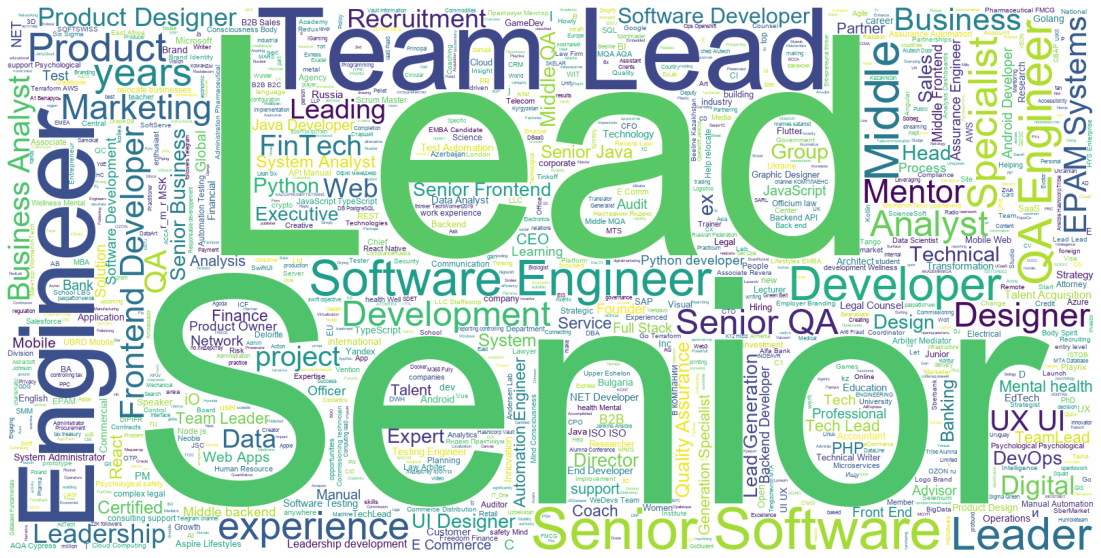

In [10]:
plt.figure(figsize=(20,10))
plt.imshow(wc)
plt.axis("off")
plt.show()

In [11]:
filtered_df.to_csv('datasets/filtered_posts_df.csv', index=False)

In [12]:
pd.read_csv('datasets/filtered_posts_df.csv')

,post_text,reacted_users_info,job_titles
0,Будет ли еще мой менторский курс по IT Рекрутм...,{'https://www.linkedin.com/in/ACoAABdk1nkBsBNQ...,"Senior DevOps, Python, Go, Terraform, AWS Seni..."
1,08.08.22 - 1й день с командой IT_One.Долгождан...,{'https://www.linkedin.com/in/ACoAADlYxTkBWDm_...,Employer brand Lead Lead System Administrator ...
2,Как менторам развивать Data Science сообщество...,{'https://www.linkedin.com/in/ACoAADe6becBwuAU...,Machine Learning Researcher | Academic Leader ...
3,Пора рассекретится! Начался новый период на бл...,{'https://www.linkedin.com/in/ACoAAD7Ow-sBU2ef...,Senior QA Automation Engineer at OZON.ru Lead ...
4,Завершился третий поток менторской программы д...,{'https://www.linkedin.com/in/ACoAAD-ysXcBrnVM...,Founder GradeBuilder | Lead QA – AstralSoft | ...
...,...,...,...
216,🎓Предикција на согорени калории за време на ве...,{'https://www.linkedin.com/in/ACoAABy0ypIB8JXI...,Senior Officer - Unit for restructuring and wo...
217,Ние от Фондация Предай Нататък сме безкрайно б...,{'https://www.linkedin.com/in/ACoAAAQTf7oBjOcB...,Human Resources Director Commercial & Human Re...
218,През изминалата седмица един от нашите основат...,{'https://www.linkedin.com/in/ACoAAD5pfkUBtWX3...,Senior Quality Assurance Engineer Input Valida...
219,През изминалата седмица един от нашите основат...,{'https://www.linkedin.com/in/ACoAADzyGWUBd59E...,Senior Sales and Customer Advisor SMM Team Lea...
